## Banana navigation

---

In [ ]:
!pip install ./python --user

### 1. Start the Environment

We begin by installing and importing the necessary packages.

In [1]:
from unityagents import UnityEnvironment
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

from dqn_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [ ]:
# Load Environment
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of actions
action_size = brain.vector_action_space_size

# examine the state space 
state = env_info.vector_observations[0]
state_size = state.shape[0]

In [3]:
def env_step(env, action):
    env_info = env.step(int(action))[brain_name]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]                
    done = env_info.local_done[0]
    
    return next_state, reward, done

def env_reset(env, train_mode=True):
    env_info = env.reset(train_mode=train_mode)[brain_name]
    state = env_info.vector_observations[0]   
    
    return state, False    

def train(agent, n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
   
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):
        state, done = env_reset(env)
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            
            next_state, reward, done = env_step(env, action)
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        
        # save most recent score
        scores_window.append(score) 
        # save most recent score
        scores.append(score)     
        # save model
        torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
        
        # decrease epsilon
        eps = max(eps_end, eps_decay*eps) 
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
    return scores

Episode 100	Average Score: 0.47
Episode 200	Average Score: 2.07
Episode 300	Average Score: 4.47
Episode 400	Average Score: 6.56
Episode 500	Average Score: 7.09
Episode 600	Average Score: 8.81
Episode 700	Average Score: 9.73
Episode 800	Average Score: 12.43
Episode 900	Average Score: 13.22
Episode 1000	Average Score: 14.75


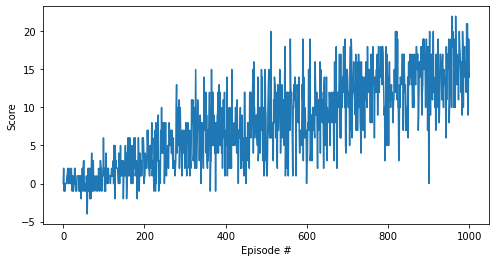

In [4]:
agent = Agent(state_size, action_size)
scores = train(agent)

# plot the scores
fig = plt.figure(figsize=(8,4))
plt.plot(scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 3. Evaluation

In [4]:
from model import QNetwork

def test(model_path,  n_episodes=100, max_t=1000):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    action_size = brain.vector_action_space_size
    state_size = state.shape[0]
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # load model
    model = QNetwork(state_size, action_size, seed=0).to(device)
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    model.eval()

    scores = []                        # list containing scores from each episode
    avg_scores = []
    scores_window = deque(maxlen=100)  # last 100 scores

    with torch.no_grad():
        for i_episode in range(1, n_episodes+1):
            state, _ = env_reset(env, train_mode=True)
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            score = 0
            for i in range(max_t):
                actions = model(state).cpu().numpy()           # get action values
                a = np.argmax(actions)                         # select the best action

                next_state, reward, done = env_step(env, a)
                next_state = torch.from_numpy(next_state).float().unsqueeze(0).to(device)

                score += reward                                # update the score
                state = next_state                             # roll over the state to next time step
                if done:                                       # exit loop if episode finished
                    break

            # save most recent score
            scores_window.append(score) 
            # save most recent score
            scores.append(score)
            avg_scores.append(np.mean(scores_window))
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    return scores, avg_scores

Episode 100	Average Score: 13.77

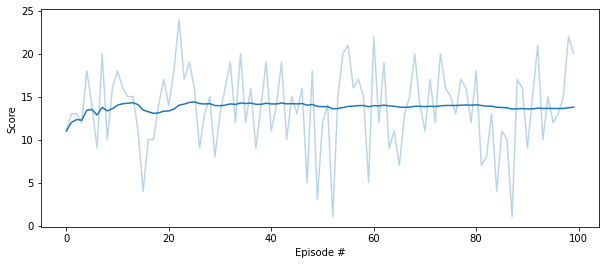

In [5]:
scores, avg = test('checkpoint.pth')
fig = plt.figure(figsize=(10,4))
plt.plot(scores, color='C0', alpha=.3)
plt.plot(avg, color='C0')
plt.ylabel('Score')
plt.xlabel('Episode #');

When finished, you can close the environment.

In [6]:
env.close()